In [1]:
import os

# List all files
trade_path = '2024_04_01_T'
quote_path = '2024_04_01_Q'

print("Trade files:", os.listdir(trade_path)[:5])  # Print first 5 to inspect
print("Quote files:", os.listdir(quote_path)[:5])


Trade files: ['ADANIENT_2024_04_01_T.asc', 'ADANIPORTS_2024_04_01_T.asc', 'APOLLOHOSP_2024_04_01_T.asc', 'ASIANPAINT_2024_04_01_T.asc', 'AXISBANK_2024_04_01_T.asc']
Quote files: ['ADANIENT_2024_04_01_Q.asc', 'ADANIPORTS_2024_04_01_Q.asc', 'APOLLOHOSP_2024_04_01_Q.asc', 'ASIANPAINT_2024_04_01_Q.asc', 'AXISBANK_2024_04_01_Q.asc']


In [2]:
import pandas as pd
import os

# Paths to folders
TRADE_DIR = "2024_04_01_T"
QUOTE_DIR = "2024_04_01_Q"

# Get symbols by removing suffixes
symbols = [f.split('_')[0] for f in os.listdir(TRADE_DIR) if f.endswith('.asc')]

all_company_data = []  # to collect final result

for symbol in symbols:
    try:
        # File paths
        trade_file = os.path.join(TRADE_DIR, f"{symbol}_2024_04_01_T.asc")
        quote_file = os.path.join(QUOTE_DIR, f"{symbol}_2024_04_01_Q.asc")

        # --- Load Trade Data ---
        trade_cols = [
            'date', 'time', 'price', 'volume', 'aggressor_side', 'trade_period',
            'trade_id', 'buyer_id', 'buy_algo_type', 'buy_order_capacity',
            'seller_id', 'sell_algo_type', 'sell_order_capacity'
        ]
        trade_df = pd.read_csv(trade_file, header=None, names=trade_cols)
        trade_df['datetime'] = pd.to_datetime(trade_df['date'] + ' ' + trade_df['time'])
        trade_df.set_index('datetime', inplace=True)
        trade_df = trade_df[trade_df['trade_period'] == '-']  # keep only regular trades

        # --- Load Quote Data ---
        quote_cols = ['date', 'time', 'bid_price', 'bid_size', 'ask_price', 'ask_size']
        quote_df = pd.read_csv(quote_file, header=None, names=quote_cols)
        quote_df['datetime'] = pd.to_datetime(quote_df['date'] + ' ' + quote_df['time'])
        quote_df.set_index('datetime', inplace=True)

        # --- Aggregate Trade Data ---
        trade_group = trade_df.resample('1min').agg({
            'price': ['first', 'max', 'min', 'last'],
            'volume': 'sum',
            'buy_order_capacity': 'sum',
            'sell_order_capacity': 'sum',
        })

        # Imbalance Ratio
        def imbalance_ratio(group):
            buys = (group == 'B').sum()
            sells = (group == 'S').sum()
            return buys / sells if sells != 0 else None

        trade_group['trade_imbalance_ratio'] = trade_df['aggressor_side'].resample('1min').apply(imbalance_ratio)

        # Weighted price
        vwap = (trade_df['price'] * trade_df['volume']).resample('1min').sum() / trade_df['volume'].resample('1min').sum()
        trade_group['weighted_price'] = vwap

        # Rename columns
        trade_group.columns = [
            'o', 'h', 'l', 'c',
            'total_volume', 'total_buy_cap', 'total_sell_cap',
            'trade_imbalance_ratio',
            'weighted_price'
        ]

        # --- Aggregate Quote Data ---
        quote_df['spread'] = quote_df['ask_price'] - quote_df['bid_price']
        quote_group = quote_df.resample('1min').agg({
            'spread': ['mean', 'max', 'min'],
            'bid_size': 'sum',
            'ask_size': 'sum',
            'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
            'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),
        })

        quote_group.columns = [
            'avg_spread', 'max_spread', 'min_spread',
            'total_bid_size', 'total_ask_size',
            'weighted_avg_bid_price', 'weighted_avg_ask_price'
        ]

        # --- Merge trade & quote ---
        merged = pd.merge(trade_group, quote_group, left_index=True, right_index=True)

        # --- Add forward return column ---
        merged['return'] = merged['c'].shift(-1) / merged['c'] - 1

        # Add symbol column
        merged['symbol'] = symbol

        # Append to master list
        all_company_data.append(merged)

        print(f"Processed: {symbol}")

    except Exception as e:
        print(f"Error processing {symbol}: {e}")


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: ADANIENT


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: ADANIPORTS


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: APOLLOHOSP


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: ASIANPAINT


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: AXISBANK


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: BAJAJ-AUTO


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: BAJAJFINSV


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: BAJFINANCE


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: BHARTIARTL


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: BPCL


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: BRITANNIA


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: CIPLA


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: COALINDIA


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: DIVISLAB


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: DRREDDY


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: EICHERMOT


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: GRASIM


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: HCLTECH


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: HDFCBANK


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: HDFCLIFE


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: HEROMOTOCO


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: HINDALCO


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: HINDUNILVR


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: ICICIBANK


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: INDUSINDBK


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: INFY


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: ITC


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: JSWSTEEL


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: KOTAKBANK


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: TCS


C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:70: RuntimeWarning: invalid value encountered in scalar divide
  'bid_price': lambda x: (x * quote_df.loc[x.index, 'bid_size']).sum() / x.sum(),
C:\Users\jayas\AppData\Local\Temp\ipykernel_18952\4275795853.py:71: RuntimeWarning: invalid value encountered in scalar divide
  'ask_price': lambda x: (x * quote_df.loc[x.index, 'ask_size']).sum() / x.sum(),


Processed: TITAN


In [6]:
full_df = pd.concat(all_company_data).dropna()
full_df


,o,h,l,c,total_volume,total_buy_cap,total_sell_cap,trade_imbalance_ratio,weighted_price,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price,return,symbol
datetime,,,,,,,,,,,,,,,,,,
2024-04-01 09:15:00,3230.20,3244.15,3215.00,3240.75,29934,3396,2970,0.970458,3233.390402,3.222845,15.95,0.05,908909,385346,13580.911472,20012.918200,0.000602,ADANIENT
2024-04-01 09:16:00,3242.15,3244.90,3232.40,3242.70,20370,2432,2191,1.052402,3238.166340,1.985751,5.25,0.05,302353,238905,10654.043716,10847.531299,-0.003300,ADANIENT
2024-04-01 09:17:00,3244.85,3248.10,3230.00,3232.00,16337,2831,2436,1.205394,3238.894822,1.735203,3.95,0.05,232745,159182,8581.935455,4841.311847,0.000449,ADANIENT
2024-04-01 09:18:00,3232.35,3235.65,3226.00,3233.45,13953,1938,1702,0.796610,3231.073339,1.630432,3.65,0.05,142395,88973,20321.595408,5784.697306,-0.001995,ADANIENT
2024-04-01 09:19:00,3231.85,3233.55,3217.25,3227.00,16914,2484,2244,0.749110,3225.153491,1.746233,4.95,0.05,373068,224915,10379.460122,21827.214119,0.002293,ADANIENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01 15:24:00,3741.00,3742.10,3738.50,3740.60,5367,783,693,0.984456,3740.015586,1.123000,2.65,0.05,89396,32404,25041.603081,1519.072165,0.000214,TITAN
2024-04-01 15:25:00,3740.60,3741.50,3739.70,3741.40,3319,509,399,3.459016,3740.911886,0.366373,1.10,0.05,25824,29678,480.904141,523.822106,0.000160,TITAN
2024-04-01 15:26:00,3741.80,3743.25,3740.80,3742.00,3936,497,456,2.814286,3741.835048,0.760761,2.30,0.05,35995,24314,2304.960862,1095.266829,0.000000,TITAN


In [13]:
features = full_df.drop(columns=['symbol', 'return'])# drop only columns that actually exist

features

,o,h,l,c,total_volume,total_buy_cap,total_sell_cap,trade_imbalance_ratio,weighted_price,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price
datetime,,,,,,,,,,,,,,,,
2024-04-01 09:15:00,3230.20,3244.15,3215.00,3240.75,29934,3396,2970,0.970458,3233.390402,3.222845,15.95,0.05,908909,385346,13580.911472,20012.918200
2024-04-01 09:15:00,429.10,430.20,429.10,429.30,112918,3189,2846,1.570858,429.607889,0.278678,1.05,0.05,2417625,3598069,29083.731201,34706.404508
2024-04-01 09:15:00,1227.00,1231.90,1226.10,1228.35,145590,2265,1790,1.059880,1228.170900,0.718896,3.20,0.05,7278168,1721979,210382.658004,287729.606273
2024-04-01 09:15:00,1553.95,1559.00,1550.00,1551.10,20230,2250,2214,0.597285,1553.250146,1.078270,4.00,0.05,330579,122343,23265.213767,8260.758585
2024-04-01 09:15:00,7261.25,7296.75,7251.55,7291.50,24466,5484,5092,0.957955,7278.372691,5.597654,17.30,0.05,258095,189979,6331.823165,6513.745115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01 15:28:00,1543.05,1544.35,1542.85,1543.45,9268,701,483,3.493827,1543.936114,0.453289,1.30,0.05,206827,303789,12172.911845,5278.608136
2024-04-01 15:28:00,9062.00,9070.00,9062.00,9062.55,1702,333,321,1.400000,9063.484166,2.004950,7.80,0.05,105701,7277,6320.501049,2891.250744
2024-04-01 15:28:00,568.40,568.80,568.40,568.75,11993,239,312,1.298246,568.564262,0.244301,0.40,0.05,397934,233203,179806.895729,46653.767269


In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Sort if needed (only if datetime is in index)
full_df = full_df.sort_index()

# Drop only existing columns
features = full_df.drop(columns=['symbol', 'return'])
target = full_df['return']

# Train/test split (time-based)
split_idx = int(0.8 * len(full_df))
X_train, X_test = features.iloc[:split_idx], features.iloc[split_idx:]
y_train, y_test = target.iloc[:split_idx], target.iloc[split_idx:]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Correlation
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Correlation between predicted and actual returns: {correlation:.4f}")


Correlation between predicted and actual returns: 0.0943


In [17]:
!pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.9 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 11.8 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.0 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]

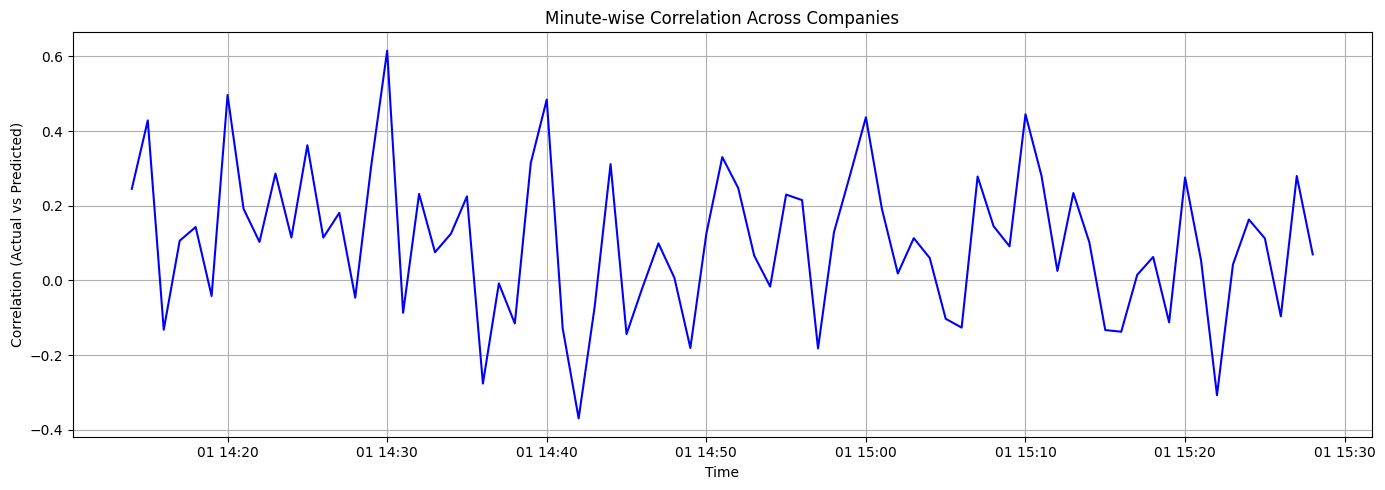

In [18]:
import matplotlib.pyplot as plt

# Reattach predictions to the test set
test_df = full_df.iloc[split_idx:].copy()
test_df['predicted_return'] = y_pred

# Group by time → check correlation across companies per minute
minute_corr = test_df.groupby(test_df.index).apply(
    lambda df: np.corrcoef(df['return'], df['predicted_return'])[0, 1] if len(df) > 1 else np.nan
)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(minute_corr.index, minute_corr.values, color='blue')
plt.xlabel('Time')
plt.ylabel('Correlation (Actual vs Predicted)')
plt.title('Minute-wise Correlation Across Companies')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
user_input = {
    'o': 250.5,
    'h': 251.0,
    'l': 249.8,
    'c': 250.9,
    'total_volume': 12000,
    'total_buy_cap': 3000,
    'total_sell_cap': 2800,
    'trade_imbalance_ratio': 1.2,
    'weighted_price': 250.85,
    'avg_spread': 0.15,
    'max_spread': 0.2,
    'min_spread': 0.1,
    'total_bid_size': 500,
    'total_ask_size': 450,
    'weighted_avg_bid_price': 250.6,
    'weighted_avg_ask_price': 250.75
}


In [22]:
import pandas as pd

# Convert to DataFrame
input_df = pd.DataFrame([user_input])

# Predict return
predicted_return = model.predict(input_df)[0]

# Show result
print(f"Predicted 1-minute return: {predicted_return:.6f}")


Predicted 1-minute return: 0.000044


In [27]:
# Create wide-form dataframe where each column is one company's return
pivot_returns = test_df.pivot_table(index=test_df.index, columns='symbol', values='return')

# Compute correlation matrix between companies
correlation_matrix = pivot_returns.corr()

# Display it
print(correlation_matrix)


symbol      ADANIENT  ADANIPORTS  APOLLOHOSP  ASIANPAINT  AXISBANK  \
symbol                                                               
ADANIENT    1.000000    0.616761    0.070704    0.034584  0.345709   
ADANIPORTS  0.616761    1.000000   -0.020792    0.092152  0.246074   
APOLLOHOSP  0.070704   -0.020792    1.000000    0.008867  0.089472   
ASIANPAINT  0.034584    0.092152    0.008867    1.000000  0.069645   
AXISBANK    0.345709    0.246074    0.089472    0.069645  1.000000   
BAJAJ-AUTO  0.144395    0.124550    0.300780   -0.055657  0.186917   
BAJAJFINSV  0.239231    0.177709   -0.063931    0.207631  0.284526   
BAJFINANCE  0.081407    0.247123    0.052763    0.069201  0.355390   
BHARTIARTL  0.160369    0.010342    0.582682    0.104496  0.079864   
BPCL        0.140662    0.121020    0.063919    0.125927 -0.080123   
BRITANNIA   0.184209    0.397509   -0.088207    0.197288  0.210924   
CIPLA       0.094847    0.134132   -0.228845    0.257795 -0.042722   
COALINDIA   0.356172

In [29]:
!pip install seaborn


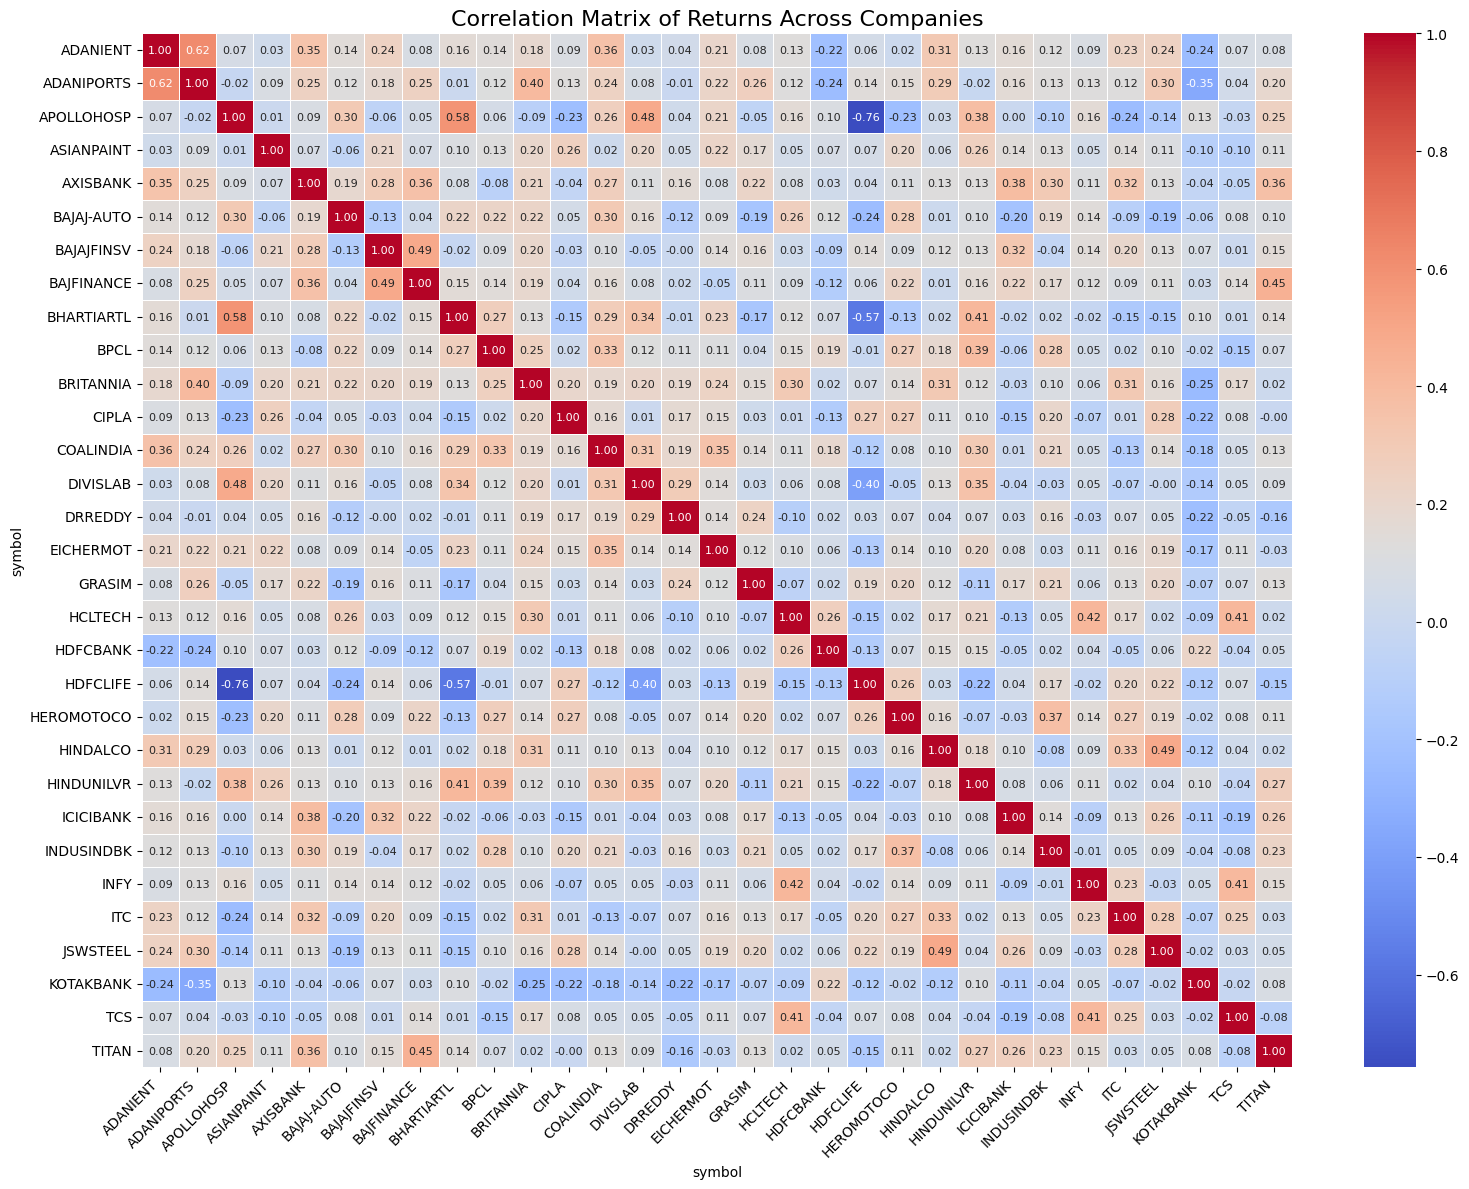

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))  # Bigger size
sns.heatmap(correlation_matrix, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f", 
            linewidths=0.5,
            annot_kws={"size": 8})  # Smaller numbers

plt.title('Correlation Matrix of Returns Across Companies', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
